In [1]:
%history -g -f "history.py"

In [1]:
sys.path.append('C:/Users/nyasha/Desktop/Masters-Nyasha/Models')

import sys
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from model_training import *
from CNN import ErnNet
from training_functions import *
from cross_validation import *

In [2]:
batch_size = 16
num_epochs = 25

In [3]:
# Extracting the training, validation and testing data
compressed_file_path = "C:/Users/nyasha/Desktop/Masters-Nyasha/Processed Data/processed_data.npz"
x_train, x_test, x_val, y_train, y_test, y_val = get_train_test_data(compressed_file_path)

# Get data loaders
train_loader, val_loader, test_loader, classes = get_data_loaders(x_train, y_train, x_val, y_val, x_test, y_test, batch_size)


In [4]:
# Check if files have been imported correctly
print(x_train.shape)  
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(12554, 128, 45)
(2696, 128, 45)
(2689, 128, 45)
(12554,)
(2696,)
(2689,)


In [5]:
lr = 1e-4
transition_steps = [10,20,30,40,50,60]
gamma = 0.8

In [6]:
device = get_device()

# Initialise model
model = ErnNet()

# Initialising training parameters
class_weights = get_class_weights(y_train, device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr)

# Scheduling parameters
scheduler = Scheduler(optimizer, transition_steps, gamma)
lr_scheduler = scheduler.get_MultiStepLR()

Running on the GPU
C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['2_walking' 'clutter/noise' 'running' 'sphere_swing' 'vehicle' 'walking'], y=['2_walking' 'sphere_swing' 'vehicle' ... 'clutter/noise' 'running'
 'sphere_swing'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
Adjusting learning rate of group 0 to 1.0000e-04.


In [7]:
# Get number of parameters in the model
sum(params.numel() for params in model.parameters())

31878

In [20]:
model_trainer = ModelTrainer(model, device, criterion, train_loader, val_loader, classes, lr_scheduler)
model_trainer.train_model(120, optimizer)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 1/100 	 Training Loss: 60.1199, Accuracy: 54.97, Testing Loss: 1.1186, Accuracy: 62.14
Validation loss decreased (inf --> 1.118608).  Saving model ...
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 2/100 	 Training Loss: 45.4291, Accuracy: 70.82, Testing Loss: 0.9585, Accuracy: 61.99
Validation loss decreased (1.118608 --> 0.958469).  Saving model ...
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 3/100 	 Training Loss: 38.8534, Accuracy: 76.25, Testing Loss: 0.9712, Accuracy: 53.51
EarlyStopping counter: 1 out of 20
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 4/100 	 Training Loss: 34.1775, Accuracy: 80.24, Testing Loss: 0.8407, Accuracy: 65.49
Validation loss decreased (0.958469 --> 0.840664).  Saving model ...
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 5/100 	 Training Loss: 30.8248, Accuracy: 82.68, Testing Loss: 0.7758, Accuracy: 68.50
Validation loss decreased (0.840664 --> 0.7

KeyboardInterrupt: 

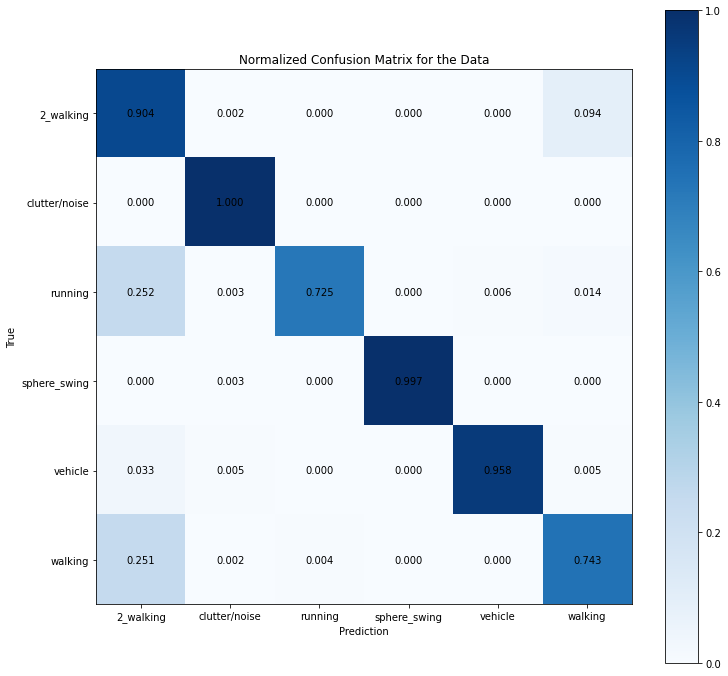

(0.3188567821531606,
 89.17813313499443,
 tensor([False, False,  True,  ..., False, False, False]),
 tensor([0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 5., 5., 0., 5., 0., 0., 0., 2., 5., 0.,
         5., 0., 0., 1., 0., 5., 0., 0., 0., 5., 0., 0., 5., 0., 5., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 5., 0., 0., 1., 0., 0., 5., 0.,
         0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 2., 0., 0., 0., 5., 5.,
         0., 0., 0., 5., 0., 0., 0., 0., 0., 5., 0., 0., 5., 0., 0., 0., 0., 0.,
         5., 0., 0., 0., 5., 4., 5., 5., 5., 0., 5., 0., 0., 0., 5., 5., 1., 0.,
         0., 0., 0., 4., 0., 0., 5., 5., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 5.,
         0., 0., 5., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0.,
         

In [9]:
model.load_state_dict(torch.load("checkpoint.pt"))
model_on_device = model.to(device)
model_trainer.evaluate_model(model_on_device, val_loader, True)

In [5]:
np.unique(y_val)

array(['2_walking', 'clutter/noise', 'running', 'sphere_swing', 'vehicle',
       'walking'], dtype='<U13')

In [34]:
# Global Averaging model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout(0.25)
        #self.fc1 = nn.Linear(32 * 30 * 9, 128)
        self.fc1 = nn.Linear(32 * 1 * 1, 6)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.dropout2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 64)

        self.dropout3 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))

        x = self.pool2(F.relu(self.conv2(x)))

        x = self.avgpool(x)

        x = x.view(-1, 32 * 1 * 1)

        x = self.fc1(x)

        #x = x.view(-1, 32 * 30 * 9)
        #x = self.dropout1(x)

        #x = F.relu(self.fc1(x))

        #x = self.dropout2(x)
        #x = F.relu(self.fc2(x))

        #x = self.dropout3(x)
        #x = self.fc3(x)
        
        return x

In [54]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)

        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32 * 32 * 11, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 32 * 32 * 11)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [2]:
# Batch Norm Model
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Block 1
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)

        self.dropout = nn.Dropout(0.5)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        # Dense layer 1
        self.fc1 = nn.Linear(64 * 1 * 1, 6)
        #self.bn3 = nn.BatchNorm1d(128)

        # Dense layer 2
        # self.fc2 = nn.Linear(128, 64)
        # self.bn4 = nn.BatchNorm1d(64)
        # self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        print(x.shape)
        # Global average pool
        x = self.avgpool(x)

        x = x.view(-1, 64 * 1 * 1)

        x = self.avgpool(x)

        x = self.fc1(x)


        # x = self.dropout(x)
        # x = F.relu(self.bn3(self.fc1(x)))
        # # x = self.dropout(x)
        # x = F.relu(self.bn4(self.fc2(x)))
        # # x = self.dropout(x)
        # x = self.fc3(x)
        return x



In [38]:
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2, 1)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32 * 16 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 16 * 5)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [34]:
# Select a model from ../Models
model_1  = Net()
device = get_device()
model_on_device = model_1.to(device) # Move model to the current device

Running on the GPU


In [18]:
images = images.to(device, dtype=torch.float)
x = model_1(images)

In [12]:
images = images.to(device, dtype=torch.float)

x = model_1.pool1(F.relu(model_1.conv1(images)))

residual = x

x = F.relu(model_1.conv2(x))
x = F.relu(model_1.conv3(x))

x += residual # Adding residual connection

x = (F.relu(model_1.conv4(x)))

"""
images = images.to(device, dtype=torch.float)
x = model_1.pool1(F.relu(model_1.conv1(images)))
print(x.shape)
x = model_1.pool2(F.relu(model_1.conv2(x)))
x = model_1.avgpool(x)
print(x.shape)
x = F.relu(model_1.conv3(x))
x = model_1.pool(F.relu(model_1.conv4(x)))
"""
x.shape

torch.Size([128, 32, 32, 11])

In [44]:
class_weights = get_class_weights(y_train, device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_on_device.parameters(), lr=1e-4)# , lr=0.01,momentum=0.9 ,momentum=0.9 , lr=0.004 , lr=0.05,momentum=0.9

In [170]:
torch.save(model_on_device, "model_cnn.pth")

In [35]:
dummy_input = torch.randn(16, 1, 128, 45, device='cuda')
torch.onnx.export(model_on_device, dummy_input, "model_cnn3.onnx", input_names=['Micro-Doppler Images'], output_names=['Walking | Two Walking | Running | Vehicle | Sphere | Noise'])

In [13]:
model_on_device = torch.load("model_cnn.pth")

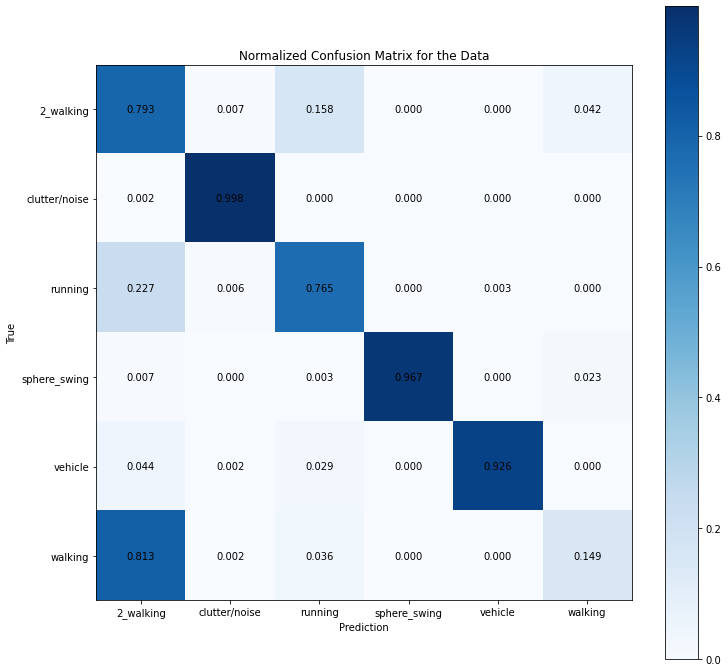

In [43]:
_, accuracy, errors, y_pred_errors, y_true_errors = model_trainer.evaluate_model(val_loader, True)

In [103]:
import random
import matplotlib.pyplot as plt
from numpy import where

def display_errors(img_errors, pred_errors, obs_errors, classes, class_of_interest=None):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5

    if class_of_interest is not None:
        # Select a specific class
        img_errors = img_errors[where(obs_errors==class_of_interest)]
        pred_errors = pred_errors[where(obs_errors==class_of_interest)]
        obs_errors = obs_errors[where(obs_errors==class_of_interest)]

    errors_idxs = random.sample(range(0, len(img_errors)), len(img_errors))

    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(14,10))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_idxs[n]
            ax[row,col].imshow((img_errors[error]).reshape((128,45)), cmap='turbo')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format( classes[int(pred_errors[error])], classes[int(obs_errors[error])]  ))
            n += 1

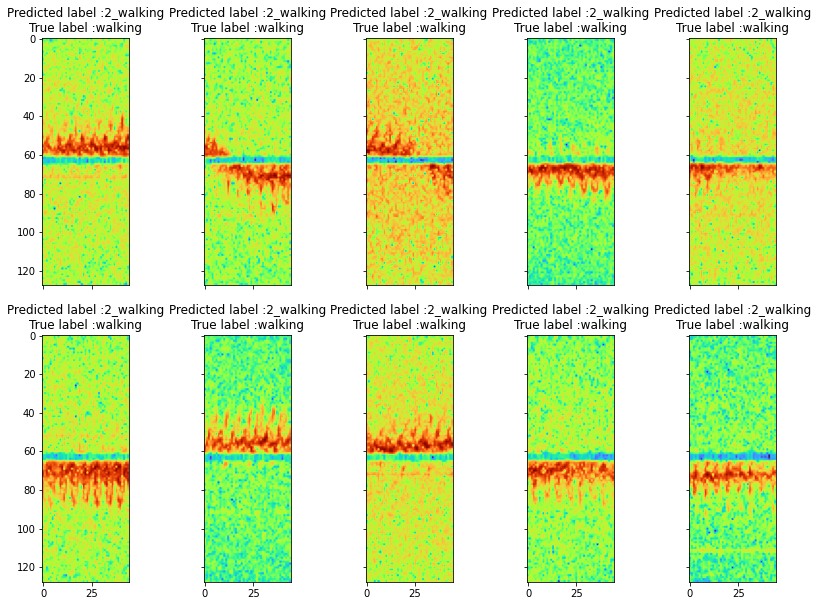

In [110]:
x_test_errors = x_val[errors]
display_errors(x_test_errors, y_pred_errors, y_true_errors, classes, 5)

In [49]:
test_dataset

In [59]:
# Adapted from https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6


In [28]:
# Save the model
torch.save(model_on_device, "model.pth")

## Training using the cross validation approach

### Adapted from https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/

In [2]:
# Extracting the training, validation and testing data
compressed_file_path = "C:/Users/nyasha/Desktop/Masters-Nyasha/Processed Data/processed_data_cv.npz"
processed_data = np.load(compressed_file_path) # Unzipping
x_train_cv = processed_data["x_train"]
y_train_cv = processed_data["y_train"]

x_test_cv = processed_data["x_test"]
y_test_cv = processed_data["y_test"]

In [3]:
num_folds = 5

network = ErnNet()
device = get_device()

# Initialising training parameters
class_weights = get_class_weights(y_train_cv, device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_data = TrainTestData(x_train_cv, y_train_cv)
test_data = TrainTestData(x_test_cv, y_test_cv)


Running on the GPU
C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['2_walking' 'clutter/noise' 'running' 'sphere_swing' 'vehicle' 'walking'], y=['sphere_swing' 'sphere_swing' 'sphere_swing' ... 'running' 'running'
 'running'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [4]:
train_dataset = train_data.get_dataset()
train_dataset.enc.classes_.tolist()

['2_walking', 'clutter/noise', 'running', 'sphere_swing', 'vehicle', 'walking']

In [5]:
cross_val = CrossValidate(network, train_data, test_data, device, criterion, 5)

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3),

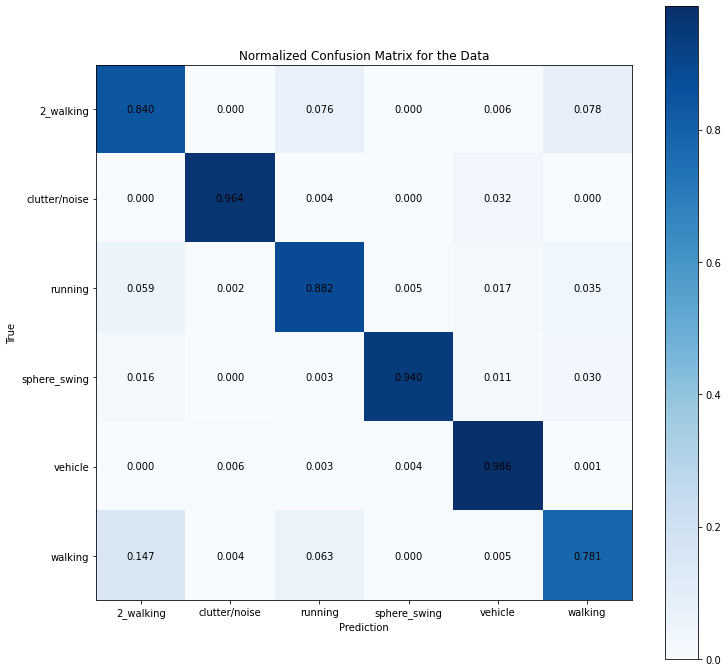

Accuracy for fold 0: 90 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 90.3065964694952 %
Average: 90.3065964694952 %
FOLD 1
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
Reset trainable parameters of la

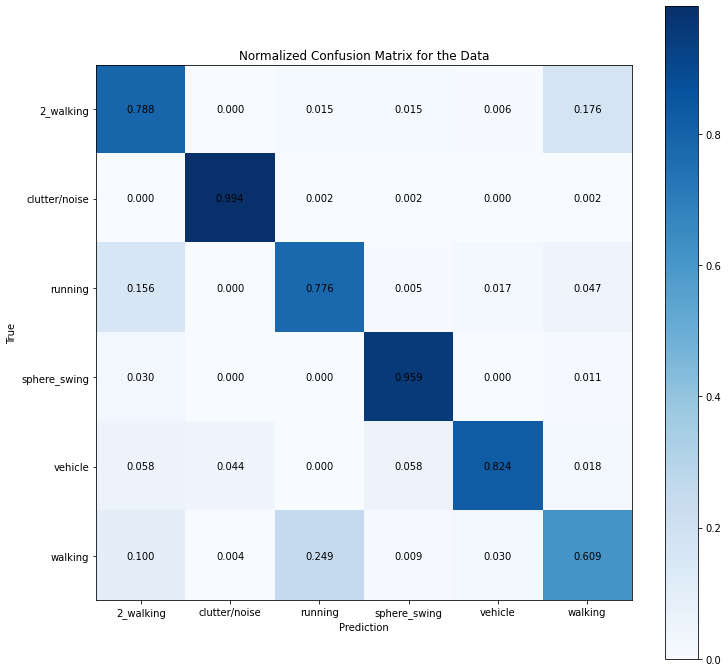

Accuracy for fold 1: 81 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 90.3065964694952 %
Fold 1: 81.69711985134717 %
Average: 86.0018581604212 %
FOLD 2
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
Rese

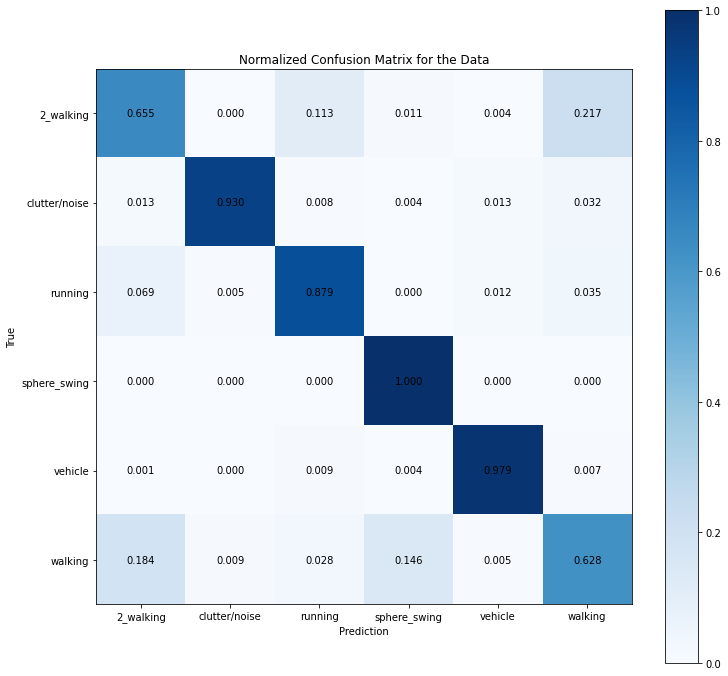

Accuracy for fold 2: 84 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 90.3065964694952 %
Fold 1: 81.69711985134717 %
Fold 2: 84.4175960346964 %
Average: 85.47377078517961 %
FOLD 3
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size

KeyboardInterrupt: 

In [6]:
cross_val.train_model(num_epochs=40, batch_size=64, scheduler=True)

In [21]:
# Extracting the training, validation and testing data
compressed_file_path = "C:/Users/nyasha/Desktop/Masters-Nyasha/Processed Data/processed_data_cv.npz"
processed_data = np.load(compressed_file_path) # Unzipping
x_train_cv = processed_data["x_train"]
y_train_cv = processed_data["y_train"]

x_test_cv = processed_data["x_test"]
y_test_cv = processed_data["y_test"]

In [ ]:
# Configuration options
device = get_device() 
k_folds = 10
num_epochs = 110


class_weights = get_class_weights(y_train_cv, device)
loss_function = nn.CrossEntropyLoss(weight=class_weights)


# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(42)

transform = transforms.Compose(
[
transforms.ToTensor()
])
# Create the datasets
dataset_train_part = HAVSDataset(x_train_cv, y_train_cv, transform=transform)
dataset_test_part = HAVSDataset(x_test_cv, y_test_cv, transform=transform)
dataset = dataset_train_part

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=k_folds, shuffle=False)


In [50]:
results = {}

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, y_train_cv)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=16, sampler=train_subsampler) # sampler=train_subsampler
    testloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=16, sampler=test_subsampler) # sampler=test_subsampler

    # Init the neural network
    network = ErnNet()
    network_on_device = network.to(device) # Move model to the current device
    network_on_device.apply(reset_weights)

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=20, verbose=True)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(network_on_device.parameters())

    # Initialize scheduler
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10,20,30,40,50,60] , gamma=0.8, last_epoch=-1, verbose=True)

    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):
        
            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device)
  
            # Zero the gradients
            optimizer.zero_grad()
            
            # Perform forward pass
            outputs = network_on_device(inputs)
            
            # Compute loss
            loss = loss_function(outputs, targets)
            
            # Perform backward pass
            loss.backward()
            
            # Perform optimization
            optimizer.step()
            
            # Print statistics
            current_loss += loss.item()
            if i % 500 == 499:
                print('Loss after mini-batch %5d: %.3f' %
                        (i + 1, current_loss / 500))
                current_loss = 0.0

        # Check early stopping
        test_loss, _, _, _, _ = evaluate_model(testloader, device, network_on_device, loss_function)

        #scheduler.step()

        early_stopping(test_loss, network_on_device)
        if early_stopping.early_stop:
            print("Early stopping")
            break           
    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')

    # Load last checkpoint (best results)
    network.load_state_dict(torch.load("checkpoint.pt"))
    network_on_device = network.to(device)

    # Saving the model
    save_path = f'./model-fold-{fold}_3.pth'
    torch.save(network_on_device.state_dict(), save_path)

    # Evaluation for this fold
    correct, total = 0, 0
    with torch.no_grad():

        # Iterate over the test data and generate predictions
        for i, data in enumerate(testloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device)
            # Generate outputs
            outputs = network_on_device(inputs)

            # Set total and correct
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        # Print accuracy
        print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        print('--------------------------------')
        results[fold] = 100.0 * (correct / total)

    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')

   500: 0.094
EarlyStopping counter: 10 out of 20
Starting epoch 34
Loss after mini-batch   500: 0.081
EarlyStopping counter: 11 out of 20
Starting epoch 35
Loss after mini-batch   500: 0.073
EarlyStopping counter: 12 out of 20
Starting epoch 36
Loss after mini-batch   500: 0.078
EarlyStopping counter: 13 out of 20
Starting epoch 37
Loss after mini-batch   500: 0.085
EarlyStopping counter: 14 out of 20
Starting epoch 38
Loss after mini-batch   500: 0.077
EarlyStopping counter: 15 out of 20
Starting epoch 39
Loss after mini-batch   500: 0.057
EarlyStopping counter: 16 out of 20
Starting epoch 40
Loss after mini-batch   500: 0.072
EarlyStopping counter: 17 out of 20
Starting epoch 41
Loss after mini-batch   500: 0.075
EarlyStopping counter: 18 out of 20
Starting epoch 42
Loss after mini-batch   500: 0.062
EarlyStopping counter: 19 out of 20
Starting epoch 43
Loss after mini-batch   500: 0.073
EarlyStopping counter: 20 out of 20
Early stopping
Training process has finished. Saving trained

In [43]:
def evaluate_model(loader, device, model_on_device, criterion, *args):

    """Evaluate Performance on test set"""
    model_on_device.eval()  # Turn off gradient computations
    num_batches = len(loader)
    correct = 0
    total = 0
    running_loss = 0
    y_tot = torch.empty(0)
    y_pred_tot = torch.empty(0)
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device).float()
            labels = labels.to(device)
            outputs = model_on_device(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

            labels = labels.cpu()
            predicted = predicted.cpu()

            y_tot = torch.cat((y_tot, labels), 0)
            y_pred_tot = torch.cat((y_pred_tot, predicted), 0)

        accuracy = 100 * correct / total
        errors = y_pred_tot - y_tot != 0
        y_pred_errors = y_pred_tot[errors]
        y_true_errors = y_tot[errors]
        # Plotting the Confusion Matrix
        assert (
            len(args) == 2 or len(args) == 0
        ), "Please insert both dataset and dataset name"
        if args:
            cm = confusion_matrix(y_tot.numpy(), y_pred_tot.numpy())
            np.set_printoptions(precision=4)

            # Coloured confusion matrix
            plt.figure(figsize=(12, 12))
            cm = confusion_matrix(y_tot.numpy(), y_pred_tot.numpy(), normalize="true")
            plt.imshow(cm, cmap=plt.cm.Blues)

            for (i, j), z in np.ndenumerate(cm):
                plt.text(j, i, "{:0.3f}".format(z), ha="center", va="center")

            plt.xticks(range(6))
            plt.yticks(range(6))
            plt.xlabel("Prediction")
            plt.ylabel("True")

            # We can retrieve the categories used by the LabelEncoder
            classes = args[0].enc.classes_.tolist()
            plt.gca().set_xticklabels(classes)
            plt.gca().set_yticklabels(classes)

            plt.title("Normalized Confusion Matrix For " + args[1] + " Data")
            plt.colorbar()
            plt.show()
        return running_loss / num_batches, accuracy, errors, y_pred_errors, y_true_errors


FOLD 0
--------------------------------
Training process has finished. Saving trained model.
Starting testing


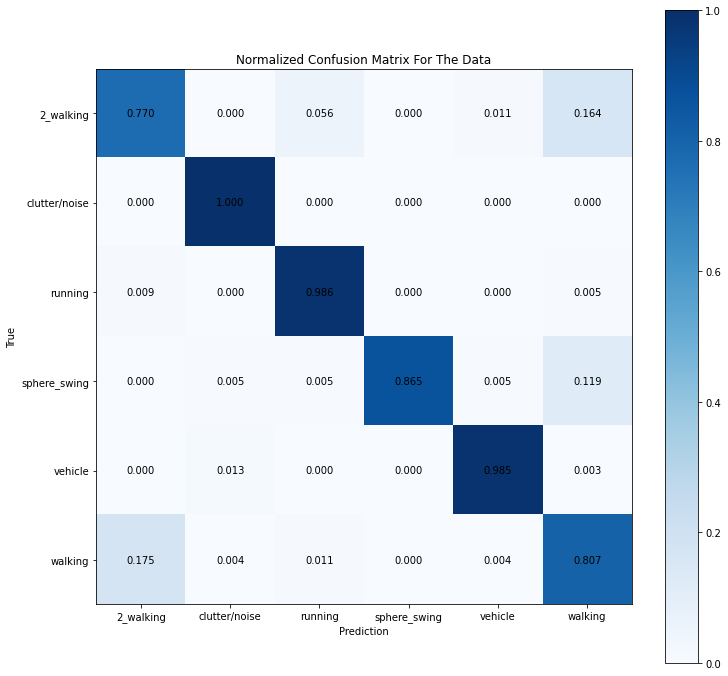

90.6501547987616
FOLD 1
--------------------------------
Training process has finished. Saving trained model.
Starting testing


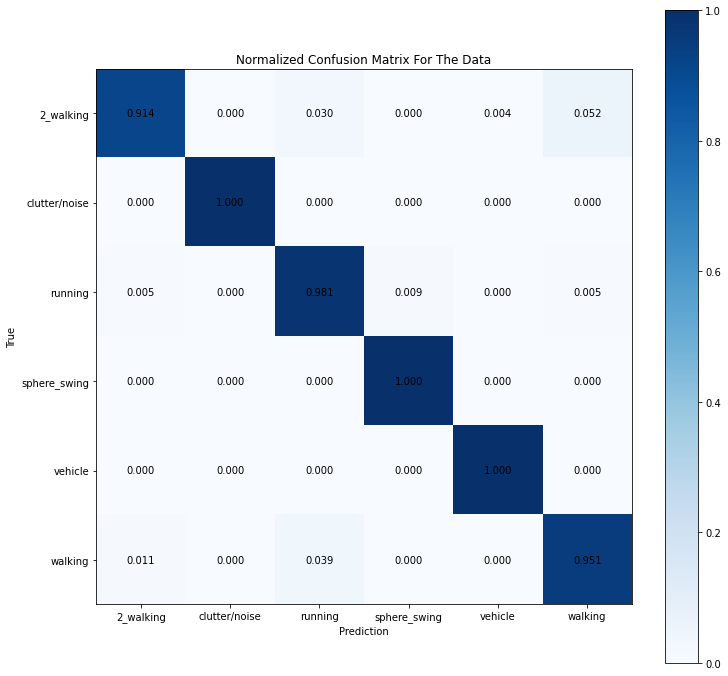

97.46130030959752
FOLD 2
--------------------------------
Training process has finished. Saving trained model.
Starting testing


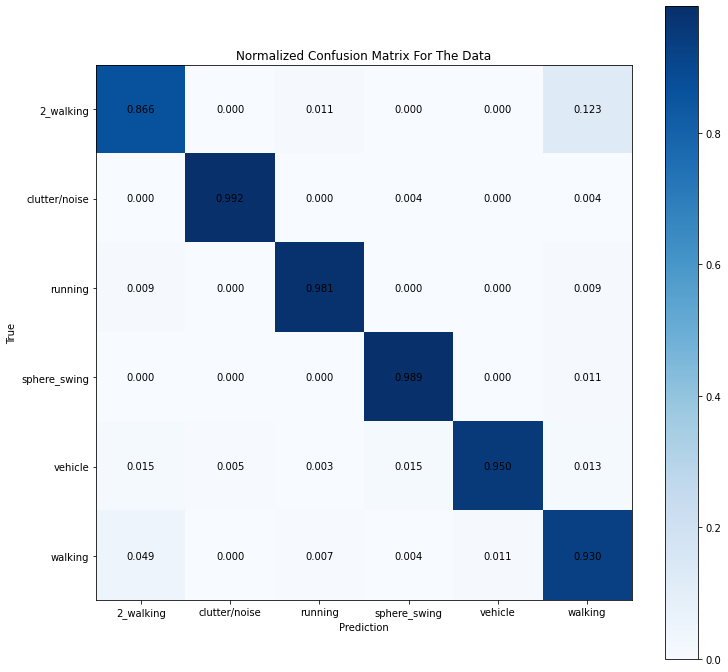

94.79553903345725
FOLD 3
--------------------------------
Training process has finished. Saving trained model.
Starting testing


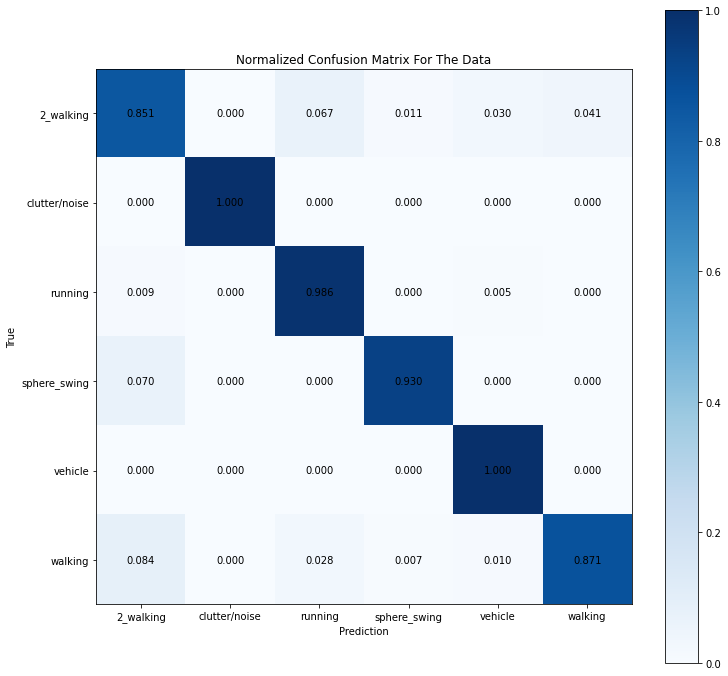

94.23791821561338
FOLD 4
--------------------------------
Training process has finished. Saving trained model.
Starting testing


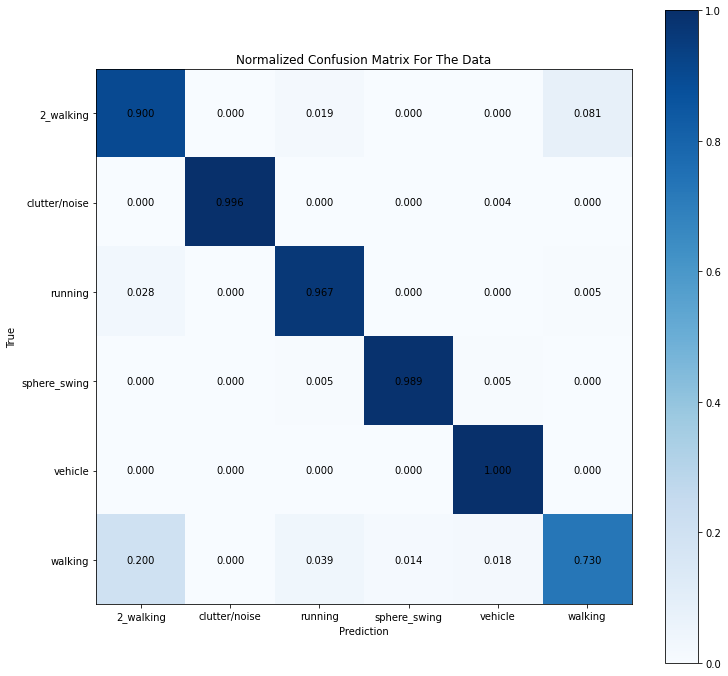

92.93680297397769
FOLD 5
--------------------------------
Training process has finished. Saving trained model.
Starting testing


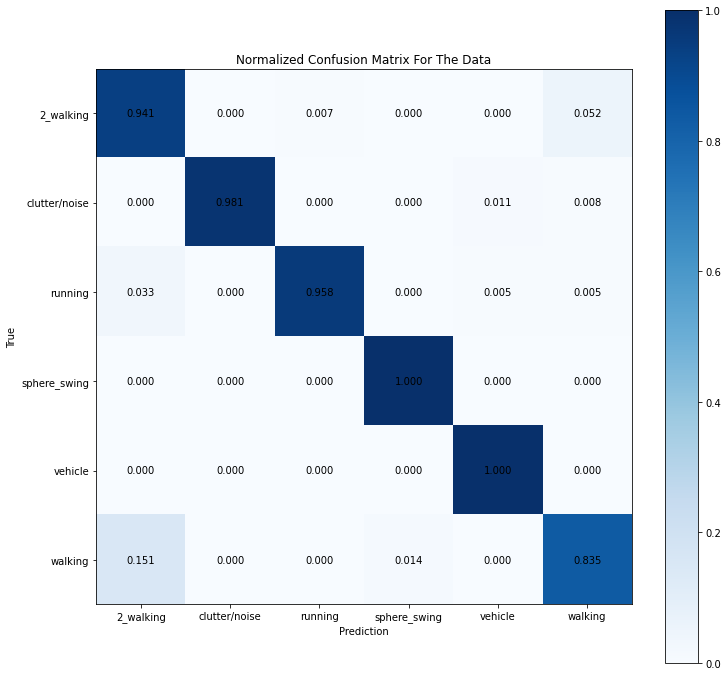

95.22924411400248
FOLD 6
--------------------------------
Training process has finished. Saving trained model.
Starting testing


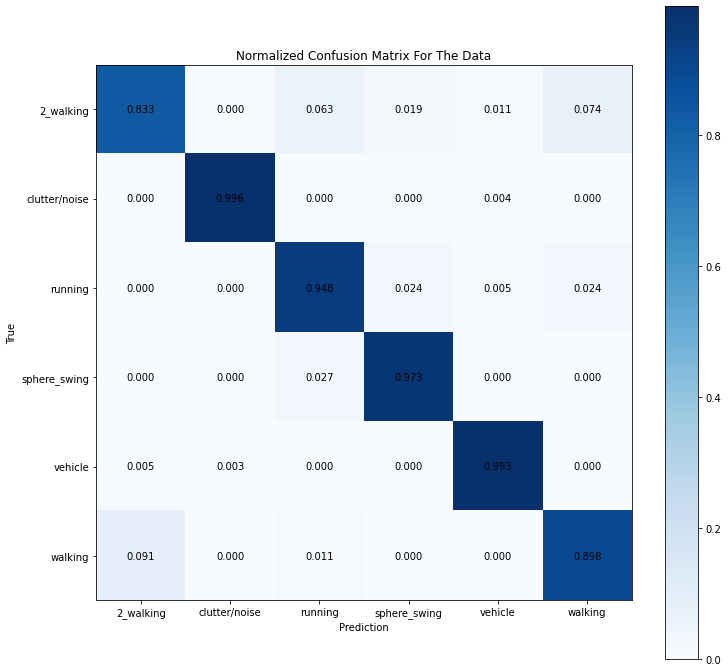

94.17596034696406
FOLD 7
--------------------------------
Training process has finished. Saving trained model.
Starting testing


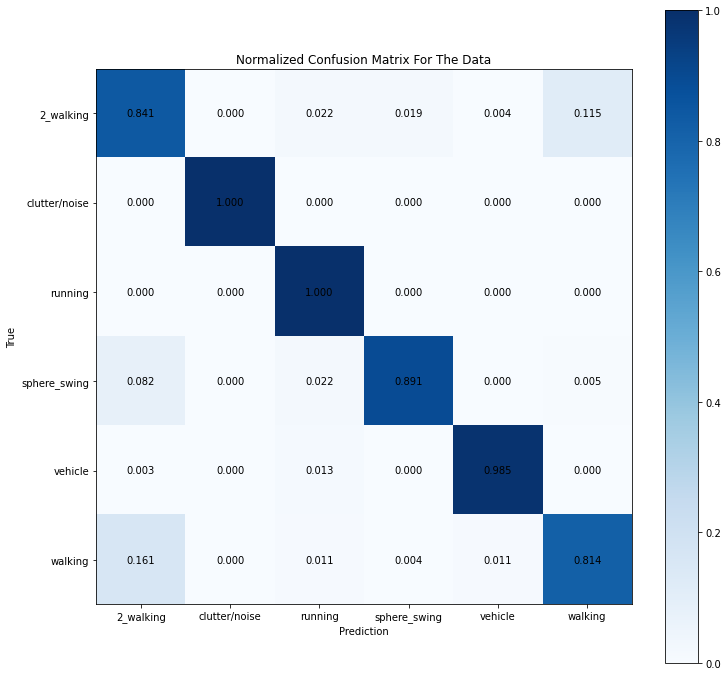

92.44114002478315
FOLD 8
--------------------------------
Training process has finished. Saving trained model.
Starting testing


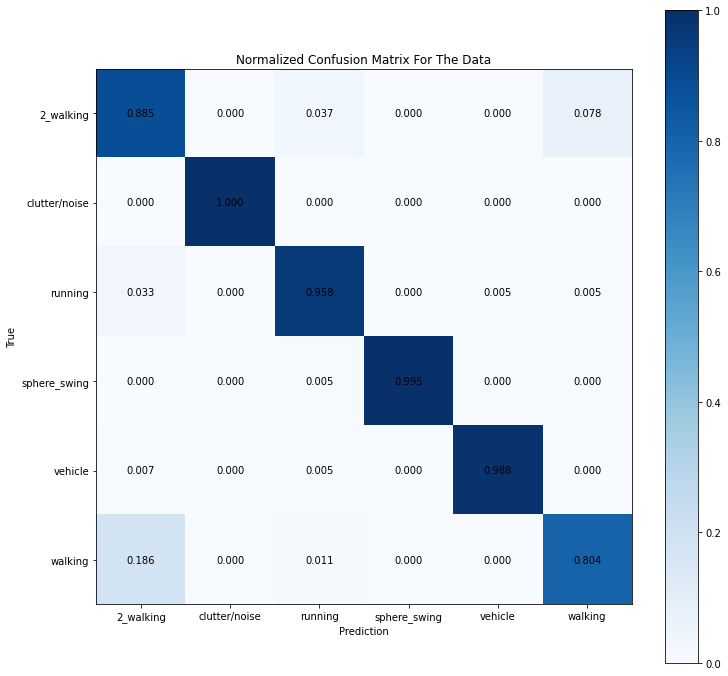

93.68029739776952
FOLD 9
--------------------------------
Training process has finished. Saving trained model.
Starting testing


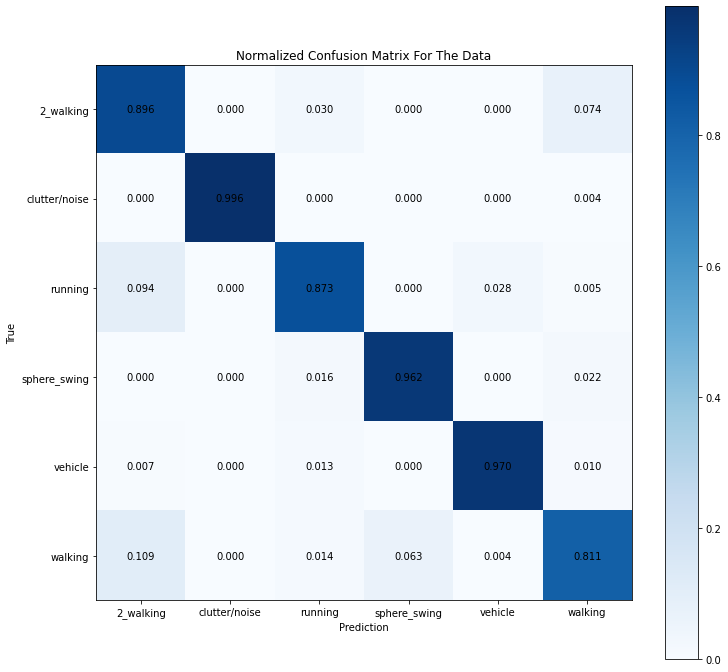

92.00743494423791


In [51]:
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, y_train_cv)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=16, sampler=train_subsampler) # sampler=train_subsampler
    testloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=16, sampler=test_subsampler) # sampler=test_subsampler

    # Initialize optimizer
    optimizer = torch.optim.Adam(network_on_device.parameters(), lr=1e-3)
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')



    # Saving the model
    save_path = f'./model-fold-{fold}_3.pth'
    # Load last checkpoint (best results)
    network.load_state_dict(torch.load(save_path))
    # Evaluation for this fold

    _, accuracy, _, _, _ = evaluate_model(testloader, device, network_on_device, criterion, dataset, 'The')
    print(accuracy)

 
    # Print fold results


In [11]:
test_loader = DataLoader(dataset=dataset_test_part, batch_size=batch_size, shuffle=False)

NameError: name 'dataset_test_part' is not defined

In [32]:
model = Net()
model.load_state_dict(torch.load('model-fold-9.pth'))
model_0_on_device = model.to(device)

evaluate_model(test_loader, device, model_0_on_device, criterion)

(0.557485631190833,
 85.7566765578635,
 tensor([False, False, False,  ..., False, False, False]),
 tensor([4., 2., 0., 3., 5., 0., 0., 0., 0., 3., 2., 0., 0., 0., 0., 0., 0., 4.,
         0., 3., 0., 0., 0., 5., 0., 0., 5., 2., 0., 1., 0., 0., 0., 3., 0., 0.,
         0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 5., 3., 0., 0., 0., 0.,
         0., 0., 0., 2., 0., 0., 3., 4., 0., 0., 0., 0., 3., 3., 0., 0., 0., 0.,
         0., 2., 0., 0., 0., 0., 3., 2., 5., 0., 5., 0., 2., 0., 0., 5., 0., 0.,
         0., 5., 0., 2., 0., 0., 2., 0., 0., 0., 0., 3., 4., 0., 2., 3., 3., 0.,
         0., 3., 3., 2., 0., 0., 0., 0., 3., 2., 4., 2., 0., 0., 0., 0., 2., 0.,
         5., 2., 0., 2., 0., 5., 0., 2., 0., 1., 4., 0., 0., 0., 0., 0., 0., 0.,
         0., 5., 0., 0., 0., 3., 0., 2., 4., 0., 4., 3., 0., 2., 0., 0., 5., 2.,
         2., 0., 0., 5., 0., 1., 0., 3., 5., 2., 0., 5., 0., 0., 2., 1., 0., 0.,
         2., 4., 0., 5., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0.,
         0.

In [81]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=dataset_train_part, batch_size=batch_size, shuffle=True)

In [82]:
model = Net()
model_0_on_device = model.to(device)
# Training the model on the whole dataset
train_model(50, train_loader, test_loader, criterion, optimizer, device, model_on_device)

Epoch: 1/50 	 Training Loss: 0.2549, Accuracy: 92.44, Testing Loss: 0.5353, Accuracy: 76.02
Validation loss decreased (inf --> 0.535278).  Saving model ...
Epoch: 2/50 	 Training Loss: 0.2223, Accuracy: 92.78, Testing Loss: 1.2239, Accuracy: 72.51
EarlyStopping counter: 1 out of 20
Epoch: 3/50 	 Training Loss: 0.2032, Accuracy: 93.23, Testing Loss: 2.9368, Accuracy: 54.31
EarlyStopping counter: 2 out of 20
Epoch: 4/50 	 Training Loss: 0.2052, Accuracy: 93.66, Testing Loss: 8.2236, Accuracy: 22.93
EarlyStopping counter: 3 out of 20
Epoch: 5/50 	 Training Loss: 0.2516, Accuracy: 93.72, Testing Loss: 0.5252, Accuracy: 79.02
Validation loss decreased (0.535278 --> 0.525191).  Saving model ...
Epoch: 6/50 	 Training Loss: 0.1915, Accuracy: 93.84, Testing Loss: 5.7389, Accuracy: 43.52
EarlyStopping counter: 1 out of 20
Epoch: 7/50 	 Training Loss: 0.1867, Accuracy: 94.07, Testing Loss: 0.3295, Accuracy: 85.42
Validation loss decreased (0.525191 --> 0.329469).  Saving model ...
Epoch: 8/50 	 

In [88]:
model = Net()
model.load_state_dict(torch.load("checkpoint.pt"))
model_on_device = model.to(device)
evaluate_model(test_loader, device, model_on_device, loss_function)

(0.3294752241189902,
 85.42014468558709,
 tensor([False, False, False,  ..., False, False, False]),
 tensor([2., 2., 4., 5., 1., 5., 5., 1., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
         2., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
         5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
         5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
         5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 2., 5., 5., 5., 5., 5.,
         5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
         5., 2., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
         5., 5., 5., 5., 5., 5., 2., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
         5., 5., 5., 5., 5., 5., 3., 5., 3., 3., 3., 2., 5., 5., 5., 5., 5., 3.,
         5., 3., 3., 3., 2., 5., 5., 5., 5., 5., 5., 3., 0., 5., 5., 5., 0., 2.,
         0., 0., 2., 2., 2., 2., 0., 2., 2., 2., 0., 4., 4., 0., 0., 0., 0., 0.,
         

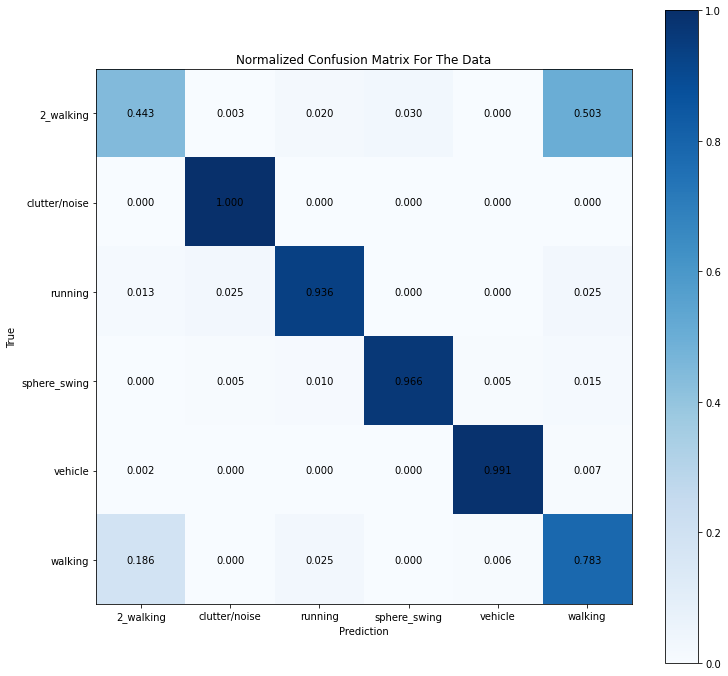

85.42014468558709

In [89]:
# Evaluate model performance on test data
#from training_functions import *
_, accuracy,errors,  y_pred_errors, y_true_errors = evaluate_model(test_loader, device, model_on_device, loss_function, train_dataset, 'The')
accuracy

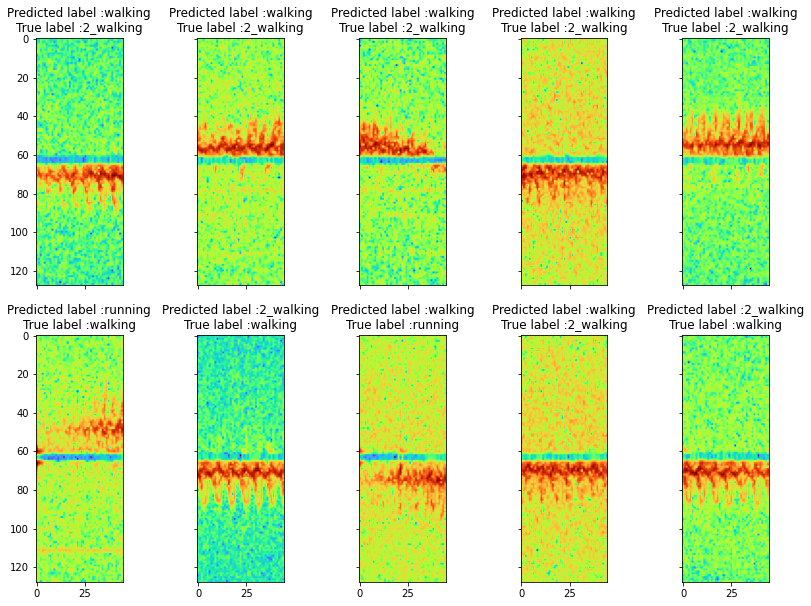

In [104]:
x_test_errors = x_test[errors]
display_errors(x_test_errors, y_pred_errors, y_true_errors, test_dataset)